In [12]:
from boxoffice.modeling.cleaned_data import X_train_dummies, X_test, y_train, y_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# now we have the relevant columns, need to standardize the data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_dummies)

# X_test_scaled = scaler.transform(X_test)

# now we can fit the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

model.fit(X_train_scaled, y_train)

/home/ag/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.587009927482587e+16, tolerance: 101351178741527.64
  model = cd_fast.enet_coordinate_descent_gram(
/home/ag/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.512663214916114e+16, tolerance: 103683792684730.42
  model = cd_fast.enet_coordinate_descent_gram(
/home/ag/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.43002544025214e+16, tolerance: 108472387841119.92
  model = cd_fast.enet_coordinate_descent_gram(
/home/ag/.pyenv/versions/3

LassoCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1), n_jobs=-1)

RMSE: 26345025.71814495
                                         coefficient
total_trailer_views                     1.735982e+07
wikipedia_pre_release_cumulative_views  1.550885e+07
top_3_trailer_views                     1.300188e+07
budget                                  9.985908e+06
distributor_slug_Walt_Disney            6.295962e+06
...                                              ...
production_method_Live_Action          -4.780493e+06
wikipedia_pre_release_week_monday      -6.668011e+06
wikipedia_pre_release_monday_views     -7.015170e+06
max_trailer_views                      -7.512322e+06
top_5_trailer_views                    -7.973636e+06

[113 rows x 1 columns]


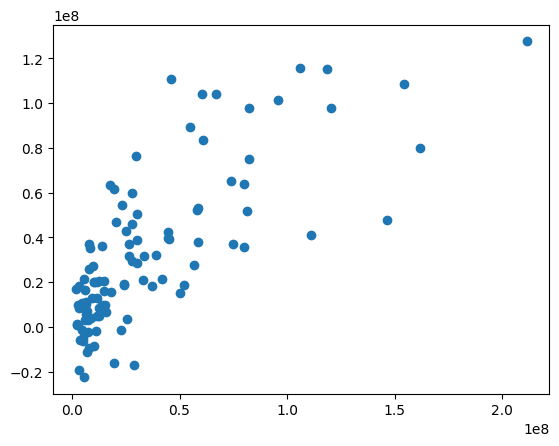

In [ ]:
# now we can evaluate the model on the test set
# need to remove the columns that were dropped from the test set
scaler_columns = X_train_dummies.columns

X_test = X_test[scaler_columns]

X_test_scaled = scaler.transform(X_test)

yhat = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, yhat)

print(f"RMSE: {rmse}")

# print the model coefficients
coefs = pd.DataFrame(model.coef_, index=scaler_columns, columns=['coefficient'])

coefs = coefs[coefs['coefficient'] != 0]

coefs = coefs.sort_values(by='coefficient', ascending=False)

print(coefs)

In [16]:
results_df = pd.DataFrame(
    {"actual": y_test, "predicted": yhat, "title": X_test["title"], "release_day_first_friday": X_test["release_day_first_friday"]}
)

# divide by 1e6 to get the values in millions
results_df["actual"] = results_df["actual"] / 1e6
results_df["predicted"] = results_df["predicted"] / 1e6

fig = px.scatter(
    results_df,
    x="actual",
    y="predicted",
    labels={"actual": "Actual Revenue (millions)", "predicted": "Predicted Revenue (millions)"},
    color="release_day_first_friday",
    hover_name="title",
    title="Actual vs Predicted Revenue",
)

fig.add_trace(go.Scatter(x=[0, 220], y=[0, 220], mode="lines", name="y=x", line=dict(color="black", dash="dash")))

fig.show()